<a href="https://colab.research.google.com/github/ismail51998/BIG_DATA_CLOUD_SENTIMENT_ANALYSIS/blob/main/projet_pfe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
pip install spark-nlp==3.3.4


In [44]:
import seaborn as sns
import pandas as pd

In [2]:
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

--2021-12-08 00:26:29--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://setup.johnsnowlabs.com/colab.sh [following]
--2021-12-08 00:26:29--  https://setup.johnsnowlabs.com/colab.sh
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2021-12-08 00:26:30--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:44

In [3]:
!bash colab.sh -p 3.1.2 -s 3.3.4

bash: colab.sh: No such file or directory


In [14]:
pip install SparkSession

ERROR: Could not find a version that satisfies the requirement SparkSession (from versions: none)
ERROR: No matching distribution found for SparkSession


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
!unzip "/content/drive/My Drive/AV articles/PySpark on Colab/black_friday_train.zip"


unzip:  cannot find or open /content/drive/My Drive/AV articles/PySpark on Colab/black_friday_train.zip, /content/drive/My Drive/AV articles/PySpark on Colab/black_friday_train.zip.zip or /content/drive/My Drive/AV articles/PySpark on Colab/black_friday_train.zip.ZIP.


In [18]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null


In [30]:
!wget -q https://www-us.apache.org/dist/spark/spark-3.2.0-bin-hadoop3.2.tgz


In [31]:
!tar xf /content/spark-3.2.0-bin-hadoop3.2.tgz


gzip: stdin: unexpected end of file
tar: Unexpected EOF in archive
tar: Unexpected EOF in archive
tar: Error is not recoverable: exiting now


In [32]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

In [34]:
pip install pyspark

In [35]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()


In [36]:
data = spark.read.csv('training.1600000.processed.noemoticon.csv',inferSchema=True,header=False)

In [39]:
data = data.toDF('target', 'id', 'date','flag','user','text')

In [40]:
data = data.select("text", "target")

In [41]:
data.groupBy("target").count().show()

+------+------+
|target| count|
+------+------+
|     4|800000|
|     0|800000|
+------+------+



In [42]:
data_pd=data.toPandas()

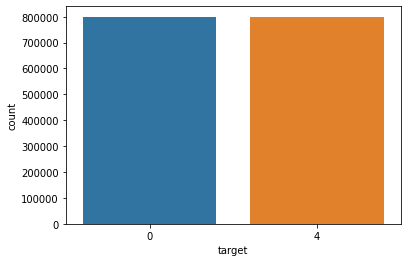

In [45]:
sns.countplot(data=data_pd,x='target')


In [46]:
data

DataFrame[text: string, target: int]

In [4]:
import sparknlp
sparknlp.start()

from sparknlp.pretrained import PretrainedPipeline

In [5]:
import sparknlp
sparknlp.start()

from sparknlp.pretrained import PretrainedPipeline

In [7]:
explain_document_pipeline = PretrainedPipeline("explain_document_ml")
annotations = explain_document_pipeline.annotate("We are very happy about SparkNLP")
print(annotations)


explain_document_ml download started this may take some time.
Approx size to download 9.1 MB
[OK!]
{'document': ['We are very happy about SparkNLP'], 'spell': ['We', 'are', 'very', 'happy', 'about', 'SparkNLP'], 'pos': ['PRP', 'VBP', 'RB', 'JJ', 'IN', 'NNP'], 'lemmas': ['We', 'be', 'very', 'happy', 'about', 'SparkNLP'], 'token': ['We', 'are', 'very', 'happy', 'about', 'SparkNLP'], 'stems': ['we', 'ar', 'veri', 'happi', 'about', 'sparknlp'], 'sentence': ['We are very happy about SparkNLP']}


In [8]:
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline

In [82]:
documentAssembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")
sentenceDetector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("Sentence")

regexTokenizer = Tokenizer() \
    .setInputCols(["Sentence"]) \
    .setOutputCol("token")
normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normalized")\
    .setLowercase(True)\
    .setCleanupPatterns(["(@[A-Za-z0-9]+)","http\S+","[^\w\d\s]"]) # remove punctuations (keep alphanumeric chars)
    # if we don't set CleanupPatterns, it will only keep alphabet letters ([^A-Za-z])

stopwords_cleaner = StopWordsCleaner()\
      .setInputCols("normalized")\
      .setOutputCol("cleanTokens")\
      .setCaseSensitive(False)
lemmatizer = Lemmatizer() \
    .setInputCols(["cleanTokens"]) \
    .setOutputCol("lemma") \
    .setDictionary("lemmas_small.txt.txt", "->", "\t")
finisher = Finisher() \
    .setInputCols(["lemma"]) \
    .setCleanAnnotations(False)
embeddings = Doc2VecApproach() \
    .setInputCols(["lemma"]) \
    .setOutputCol("embeddings")

In [83]:
pipeline = Pipeline() \
    .setStages([
      documentAssembler,
      sentenceDetector,
      regexTokenizer,
      normalizer,
      stopwords_cleaner,
      lemmatizer,
      finisher,
      embeddings
    ])

In [ ]:
m=pipeline.fit(data)

In [73]:
df=m.transform(data)

In [74]:
df.show()

+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|target|            document|            Sentence|               token|          normalized|         cleanTokens|               lemma|      finished_token|
+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|@switchfoot http:...|     0|[[document, 0, 11...|[[document, 0, 60...|[[token, 0, 10, @...|[[token, 39, 42, ...|[[token, 39, 42, ...|[[token, 39, 42, ...|[@switchfoot, htt...|
|is upset that he ...|     0|[[document, 0, 11...|[[document, 0, 56...|[[token, 0, 1, is...|[[token, 0, 1, is...|[[token, 3, 7, up...|[[token, 3, 7, up...|[is, upset, that,...|
|@Kenichan I dived...|     0|[[document, 0, 88...|[[document, 0, 41...|[[token, 0, 8, @K...|[[token, 10, 10, ...|[[